#### Grab a random molecule from FreeSolv, parameterize with OpenFF 1.2.0, generate some configuration snapshots

In [1]:
import openforcefield
openforcefield.__version__

In [2]:
from openforcefield.topology import Molecule
from openforcefield.typing.engines.smirnoff import ForceField
forcefield = ForceField('openff-1.2.0.offxml')

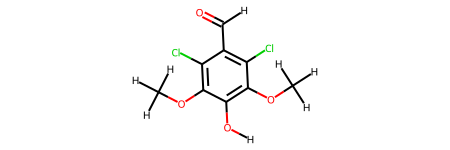

In [3]:
# random molecule from freesolv database.txt
# https://github.com/MobleyLab/FreeSolv/blob/ff0961a3177863c8002e8487ff9718c513974138/database.txt#L397
offmol = Molecule.from_smiles('COc1c(c(c(c(c1Cl)C=O)Cl)OC)O')
offmol

In [4]:
offmol.compute_partial_charges_am1bcc()

In [5]:
offmol.generate_conformers()

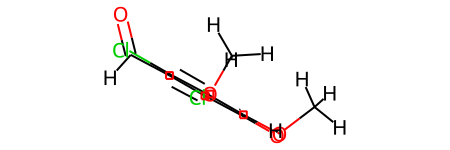

In [6]:
offmol.to_rdkit()

In [7]:
len(offmol.conformers)

1

In [8]:
sys = forcefield.create_openmm_system(offmol.to_topology())
top = offmol.to_topology().to_openmm()

In [9]:
from simtk import unit
from simtk import openmm as mm
from simtk.openmm import app


temperature = 300 * unit.kelvin
gamma = 100.0 / unit.picosecond
dt = 1.0 * unit.femtosecond

sim = app.Simulation(top, sys, mm.LangevinIntegrator(temperature, gamma, dt))

In [10]:
off_charges = offmol.partial_charges

In [11]:
nb_force = sys.getForce(0)
nb_force

<simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7ffd87a76d80> >

In [12]:
N = offmol.n_atoms
N

23

In [13]:
omm_charges = []
for i in range(N):
    omm_charges.append(nb_force.getParticleParameters(i)[0])

In [14]:
charge_differences = [omm_charges[i] - off_charges[i] for i in range(N)]
charge_differences

[Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementa

In [15]:
sim.context.setPositions(offmol.conformers[0])

In [16]:
def get_energy():
    return sim.context.getState(getEnergy=True).getPotentialEnergy()

In [17]:
get_energy()

Quantity(value=258.4339904785156, unit=kilojoule/mole)

In [18]:
sim.minimizeEnergy()

In [19]:
get_energy()

Quantity(value=242.51620483398438, unit=kilojoule/mole)

In [20]:
sim.context.setVelocitiesToTemperature(temperature)

In [21]:
def get_positions():
    return sim.context.getState(getPositions=True).getPositions(asNumpy=True)

In [22]:
get_positions()

Quantity(value=array([[ 0.25787252,  0.02050192, -0.19939502],
       [ 0.20957561, -0.10400783, -0.14720073],
       [ 0.19580406, -0.10378213, -0.0098293 ],
       [ 0.29582617, -0.16354832,  0.06761356],
       [ 0.28628427, -0.16435738,  0.20790081],
       [ 0.1743831 , -0.10668242,  0.27013183],
       [ 0.07211669, -0.04751066,  0.19314739],
       [ 0.0823373 , -0.04789897,  0.0519701 ],
       [-0.04737184,  0.01389246, -0.04980485],
       [-0.04333544,  0.0122078 ,  0.26227048],
       [-0.10133274,  0.11306173,  0.22370285],
       [ 0.16506597, -0.1072682 ,  0.44578177],
       [ 0.38360867, -0.22357166,  0.28573391],
       [ 0.50545275, -0.14874387,  0.29327917],
       [ 0.40126154, -0.22257276,  0.00262366],
       [ 0.26751426,  0.01357658, -0.30817151],
       [ 0.35597834,  0.04417292, -0.15710716],
       [ 0.18885079,  0.10214639, -0.1760828 ],
       [-0.0755612 , -0.02902563,  0.35737294],
       [ 0.57527167, -0.19916944,  0.36076942],
       [ 0.48599979, -0.0

In [23]:
%%time
sim.step(10000)

CPU times: user 134 ms, sys: 75.9 ms, total: 210 ms
Wall time: 344 ms


In [24]:
from espaloma.units import DISTANCE_UNIT, ENERGY_UNIT

Using backend: pytorch


In [25]:
import torch
torch.set_default_dtype(torch.float64)

import numpy as np

In [26]:
from tqdm import tqdm
xyz = []
vacuum_energies = []

n_samples = 100

for _ in tqdm(range(n_samples)):
    sim.step(1000)
    xyz.append(get_positions().value_in_unit(DISTANCE_UNIT))
    vacuum_energies.append(get_energy().value_in_unit(ENERGY_UNIT))
vacuum_energies = torch.tensor(vacuum_energies)

100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


In [27]:
print(DISTANCE_UNIT)

bohr


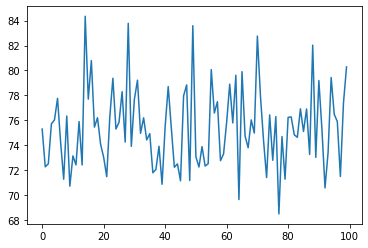

In [28]:
import matplotlib.pyplot as plt

plt.plot((vacuum_energies * ENERGY_UNIT).value_in_unit(unit.kilocalorie_per_mole))

In [29]:
N = len(xyz[0])
N

23

#### Pre-compute pairwise distance matrices

In [30]:
xyz[0]

array([[ 3.10273981, -0.49210469, -3.65302211],
       [ 2.67651108, -2.76366072, -2.2229749 ],
       [ 3.81121297, -2.79321427,  0.25264908],
       [ 6.03243455, -4.13406678,  0.63373747],
       [ 7.37241187, -4.06719339,  3.07138942],
       [ 6.16482518, -2.73875623,  5.00538889],
       [ 3.82467725, -1.40758257,  4.64618954],
       [ 2.56336973, -1.58748538,  2.37931585],
       [-0.40904309, -0.1142213 ,  1.7478566 ],
       [ 2.95237972,  0.20927028,  6.77842128],
       [ 0.60614886,  0.61540419,  7.03687463],
       [ 7.58288829, -2.64302172,  7.95231672],
       [ 9.46766394, -5.47006044,  3.4980535 ],
       [11.69783532, -4.82595169,  2.15515973],
       [ 7.21061974, -5.29501269, -1.39317623],
       [ 1.70762975,  0.9605137 , -3.18470817],
       [ 2.91373331, -1.13446958, -5.60938892],
       [ 4.89405507,  0.50272969, -3.37513869],
       [ 4.08869935,  1.3269612 ,  8.06970249],
       [11.55494584, -5.29755771,  0.14695279],
       [13.25181853, -5.84062311,  3.066

In [31]:
from scipy.spatial.distance import pdist, squareform

# these are espaloma units of bohr
distance_matrices = [torch.tensor(squareform(pdist(conf))) for conf in xyz]
distance_matrices = torch.stack(distance_matrices)

In [32]:
(torch.median(distance_matrices[0]) * DISTANCE_UNIT).value_in_unit(unit.angstrom)

tensor(4.0081)

In [33]:
radii = (torch.ones(N) * unit.angstroms).value_in_unit(DISTANCE_UNIT)
scales = torch.ones(N)

In [34]:
radii.shape, scales.shape

(torch.Size([23]), torch.Size([23]))

In [35]:
radii, scales

(tensor([1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897,
         1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897,
         1.8897, 1.8897, 1.8897, 1.8897, 1.8897]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.]))

In [36]:
offmol.partial_charges

Quantity(value=array([ 0.11063   , -0.32578999,  0.04101   ,  0.13609999,  0.04101   ,
        0.06506   , -0.19729   ,  0.06506   , -0.04672   ,  0.58569002,
       -0.49212   , -0.04672   , -0.32578999,  0.11063   , -0.4727    ,
        0.04844   ,  0.04844   ,  0.04844   ,  0.02066   ,  0.04844   ,
        0.04844   ,  0.04844   ,  0.44064   ]), unit=elementary charge)

In [37]:
charges = torch.tensor([c / unit.elementary_charge for c in off_charges])

#### Compute hydration free energy difference using EXP


In [38]:
from espaloma.mm.implicit import gbsa_obc2_energy

In [39]:
# TODO: jit this, bro

def compute_obc2_energies(distance_matrices, radii, scales, charges):
    N = len(distance_matrices)
    E_s = torch.zeros(N)
    for i in range(N):
        E_s[i] += gbsa_obc2_energy(
            distance_matrices[i],
            radii, scales, charges
        )
    return E_s

In [40]:
len(distance_matrices)

100

In [41]:
obc2_energies = compute_obc2_energies(distance_matrices, radii, scales, charges)

In [42]:
obc2_energies

tensor([0.0094, 0.0094, 0.0092, 0.0092, 0.0093, 0.0095, 0.0093, 0.0093, 0.0093,
        0.0093, 0.0092, 0.0092, 0.0093, 0.0092, 0.0094, 0.0095, 0.0093, 0.0094,
        0.0091, 0.0093, 0.0093, 0.0094, 0.0094, 0.0091, 0.0094, 0.0091, 0.0092,
        0.0092, 0.0094, 0.0094, 0.0093, 0.0094, 0.0093, 0.0093, 0.0093, 0.0094,
        0.0094, 0.0093, 0.0093, 0.0092, 0.0093, 0.0094, 0.0093, 0.0093, 0.0092,
        0.0094, 0.0092, 0.0092, 0.0092, 0.0093, 0.0092, 0.0095, 0.0094, 0.0092,
        0.0093, 0.0091, 0.0092, 0.0093, 0.0093, 0.0093, 0.0091, 0.0093, 0.0094,
        0.0091, 0.0093, 0.0092, 0.0093, 0.0093, 0.0092, 0.0091, 0.0088, 0.0091,
        0.0092, 0.0091, 0.0093, 0.0093, 0.0090, 0.0093, 0.0092, 0.0091, 0.0094,
        0.0092, 0.0092, 0.0091, 0.0091, 0.0094, 0.0090, 0.0090, 0.0091, 0.0092,
        0.0094, 0.0094, 0.0092, 0.0092, 0.0093, 0.0091, 0.0093, 0.0094, 0.0089,
        0.0093])

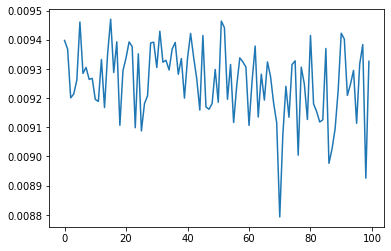

In [43]:
plt.plot(obc2_energies.detach().numpy())

In [44]:
radii

tensor([1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897,
        1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897,
        1.8897, 1.8897, 1.8897, 1.8897, 1.8897])

In [45]:
from openmmtools.constants import kB
kT = kB * temperature

In [46]:
to_kT = 1.0 * ENERGY_UNIT / kT
to_kT

1052.5821686494048

In [47]:
w = (obc2_energies - vacuum_energies) * to_kT
w

tensor([-116.4095, -111.3584, -111.9397, -117.3015, -117.7850, -120.4813,
        -114.7394, -109.7494, -118.3087, -108.8577, -113.0080, -111.8046,
        -117.4892, -111.8177, -131.6528, -120.3652, -125.7520, -116.6718,
        -118.2465, -114.4787, -112.6761, -109.9996, -118.0930, -123.5667,
        -116.4645, -117.6583, -121.6660, -114.8628, -130.6571, -114.0881,
        -120.5344, -122.9635, -115.9139, -117.9993, -115.0527, -115.8236,
        -110.5313, -111.1005, -114.1609, -109.1837, -116.8131, -122.1053,
        -116.6566, -111.4065, -111.9658, -109.4221, -121.1267, -122.6051,
        -109.7123, -130.4344, -112.9174, -111.2307, -114.0041, -111.6414,
        -111.8271, -124.7130, -118.7302, -120.1555, -112.2301, -113.1607,
        -117.6110, -122.6036, -117.2580, -123.9298, -107.0384, -124.3545,
        -115.5478, -114.0263, -117.8675, -116.1729, -129.5708, -121.2121,
        -115.0835, -110.1570, -118.4045, -112.2780, -118.5003, -105.0793,
        -115.5590, -109.9492, -117.970

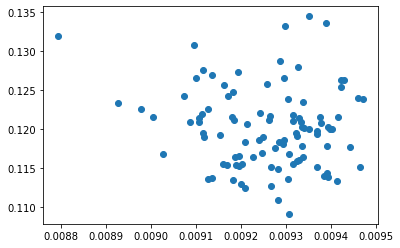

In [48]:
plt.scatter(obc2_energies, vacuum_energies)

(array([ 4.,  1.,  5., 10., 11., 25., 15., 17., 10.,  2.]),
 array([-131.65283821, -128.99548587, -126.33813353, -123.68078119,
        -121.02342884, -118.3660765 , -115.70872416, -113.05137182,
        -110.39401948, -107.73666714, -105.0793148 ]),
 <BarContainer object of 10 artists>)

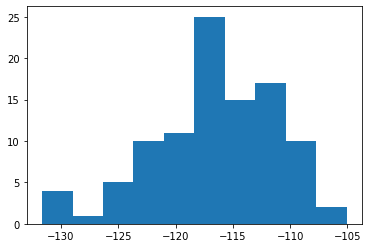

In [49]:
plt.hist(w.detach().flatten().numpy())

In [50]:
w.detach().flatten().numpy().std()

5.382962769559849

In [51]:
def one_sided_exp(w):
    delta_f = - (torch.logsumexp(- w, dim=(0,)) - np.log(len(w)))
    return delta_f

In [52]:
w.mean()

tensor(-116.6963)

In [53]:
torch.logsumexp(w, dim=(0,))

tensor(-104.8227)

In [54]:
from scipy.special import logsumexp
logsumexp(w)

-104.82268344971003

In [55]:
%%time
one_sided_exp(w)

CPU times: user 402 µs, sys: 161 µs, total: 563 µs
Wall time: 374 µs


tensor(-127.6487)

In [56]:
((one_sided_exp(w) / to_kT).detach() * ENERGY_UNIT).value_in_unit(unit.kilocalorie_per_mole)

tensor(-76.0993)

#### TODO: huh, fishy that this is off by so much... Initial prediction is a hydration free energy of -75 kcal/mol????

#### TODO: double-check against timemachine implementation and against openmm implementation

In [58]:
expt_delta_f = -8.68 * unit.kilocalorie_per_mole / kT
expt_delta_f

-14.559801248448967

In [59]:
radii.requires_grad_()
scales.requires_grad_()

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.], requires_grad=True)

In [60]:
sum([c.value_in_unit(unit.elementary_charge) for c in off_charges])

1.6763806343078613e-08

In [61]:
#def free_energy_loss(distance_matrices, radii, scales, charges):
#    w = compute_obc2_energies(distance_matrices, radii, scales, charges) - vacuum_energies
#    pred_delta_f = one_sided_exp(w)
#    return torch.sqrt((pred_delta_f - expt_delta_f)**2)

In [62]:
# NOTE: compilation time blows up because it attempts to inline the entire
# loop over the training data...
#fast_free_energy_loss = torch.jit.trace(
#    free_energy_loss,
#    (distance_matrices, radii, scales, charges),
#)

In [63]:
def free_energy_loss(radii, scales, charges, inds):
    """compute hydration free energy using the subset of snapshots indexed by inds"""
    solv_energies = compute_obc2_energies(distance_matrices[inds], radii, scales, charges)
    W = solv_energies - vacuum_energies[inds]
    w = W * to_kT
    pred_delta_f = one_sided_exp(w)
    return torch.sqrt((pred_delta_f - expt_delta_f)**2)

#### Check ability to fit to expt free energy target if all radii and scales are free parameters

In [64]:
radii = (torch.ones(N) * unit.angstroms).value_in_unit(DISTANCE_UNIT)
scales = torch.ones(N)
radii, scales

(tensor([1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897,
         1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897,
         1.8897, 1.8897, 1.8897, 1.8897, 1.8897]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.]))

In [65]:
radii.requires_grad_()
scales.requires_grad_()

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.], requires_grad=True)

In [66]:
learning_rate = 1e-3
optimizer = torch.optim.Adam([radii, scales], lr=learning_rate)

In [67]:
distance_matrices.shape

torch.Size([100, 23, 23])

In [68]:
radii_traj = [np.array(radii.detach().numpy())]
scales_traj = [np.array(scales.detach().numpy())]

n_snapshots_per_batch = 25
batch_losses = []
trange = tqdm(range(1000))
for t in trange:
    batch_inds = np.random.choice(range(len(distance_matrices)), n_snapshots_per_batch)
    L = free_energy_loss(radii, scales, charges, batch_inds)
    
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    batch_losses.append(L.detach().numpy())
    trange.set_postfix(batch_loss=batch_losses[-1])
    
    
    radii_traj.append(np.array(radii.detach().numpy()))
    scales_traj.append(np.array(scales.detach().numpy()))

100%|██████████| 1000/1000 [00:56<00:00, 17.60it/s, batch_loss=1.0781876689099104]


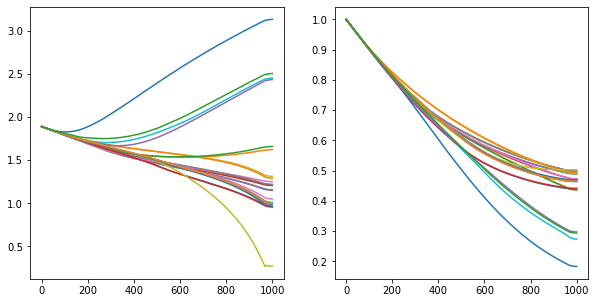

In [69]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(np.array(radii_traj))
plt.subplot(1,2,2)
plt.plot(np.array(scales_traj))

In [70]:
loss_traj_in_kcalmol = [(b * kT).value_in_unit(unit.kilocalorie_per_mole) for b in batch_losses]

(0.0, 71.41564529465501)

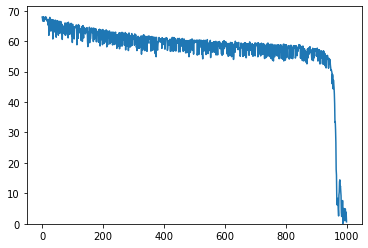

In [71]:
plt.plot(loss_traj_in_kcalmol)
plt.ylim(0,)

#### Double-check estimate variance under configuration subsampling

In [72]:
losses = []
for _ in tqdm(range(100)):
    batch_inds = np.random.choice(range(len(distance_matrices)), n_snapshots_per_batch)
    L = float(free_energy_loss(radii, scales, charges, batch_inds).detach())
    losses.append(L)

100%|██████████| 100/100 [00:02<00:00, 38.09it/s]


Text(0, 0.5, 'frequency')

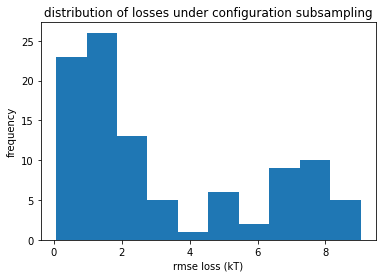

In [73]:
plt.title('distribution of losses under configuration subsampling')
plt.hist(losses);
plt.xlabel('rmse loss (kT)')
plt.ylabel('frequency')

#### Now let's get a graph net in the mix!

In [84]:
from espaloma.redux.nn import TAG, MLP
from espaloma.redux.symmetry import ValenceModel, Readouts, elements

def initialize(hidden_dim=128, node_dim=128):
    node_representation = TAG(in_dim=len(elements), hidden_dim=hidden_dim, out_dim=node_dim)
    readouts = Readouts(atoms=MLP(node_dim, 2), bonds=MLP(2 * node_dim, 2), angles=MLP(3 * node_dim, 2),
                        propers=MLP(4 * node_dim, 6), impropers=MLP(4 * node_dim, 6))
    valence_model = ValenceModel(node_representation, readouts)
    return valence_model

In [85]:
valence_model = initialize()

In [86]:
params = valence_model.forward(offmol)

In [87]:
radii = params.atoms[:,0]
scales = params.atoms[:,1]
radii, scales

(tensor([0.1023, 0.0858, 0.0914, 0.0903, 0.0914, 0.0747, 0.0845, 0.0747, 0.0912,
         0.0870, 0.0910, 0.0912, 0.0858, 0.1023, 0.0934, 0.0915, 0.0915, 0.0915,
         0.0924, 0.0915, 0.0915, 0.0915, 0.0909], grad_fn=<SelectBackward>),
 tensor([0.1395, 0.1052, 0.1179, 0.1098, 0.1179, 0.1143, 0.1161, 0.1143, 0.1090,
         0.1260, 0.1035, 0.1090, 0.1052, 0.1395, 0.1199, 0.0993, 0.0993, 0.0993,
         0.1003, 0.0993, 0.0993, 0.0993, 0.1028], grad_fn=<SelectBackward>))

In [88]:
def predict_obc2_params(offmol):
    """output of graph net's atom representation will initially be near zero, just offset by +1"""
    params = valence_model.forward(offmol)
    radii = params.atoms[:,0] + 1
    scales = params.atoms[:,1] + 1
    return radii, scales

In [89]:
radii, scales = predict_obc2_params(offmol)
radii, scales

(tensor([1.1023, 1.0858, 1.0914, 1.0903, 1.0914, 1.0747, 1.0845, 1.0747, 1.0912,
         1.0870, 1.0910, 1.0912, 1.0858, 1.1023, 1.0934, 1.0915, 1.0915, 1.0915,
         1.0924, 1.0915, 1.0915, 1.0915, 1.0909], grad_fn=<AddBackward0>),
 tensor([1.1395, 1.1052, 1.1179, 1.1098, 1.1179, 1.1143, 1.1161, 1.1143, 1.1090,
         1.1260, 1.1035, 1.1090, 1.1052, 1.1395, 1.1199, 1.0993, 1.0993, 1.0993,
         1.1003, 1.0993, 1.0993, 1.0993, 1.1028], grad_fn=<AddBackward0>))

In [90]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(valence_model.parameters(), lr=learning_rate)

In [91]:
radii_traj = [np.array(radii.detach().numpy())]
scales_traj = [np.array(scales.detach().numpy())]

batch_losses = []
trange = tqdm(range(1000))

n_snapshots_per_batch = 25

for t in trange:
    batch_inds = np.random.choice(range(len(distance_matrices)), n_snapshots_per_batch)
    
    radii, scales = predict_obc2_params(offmol)
    L = free_energy_loss(radii, scales, charges, batch_inds)
    
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    batch_losses.append(L.detach().numpy())
    trange.set_postfix(batch_loss=batch_losses[-1])
    
    
    radii_traj.append(np.array(radii.detach().numpy()))
    scales_traj.append(np.array(scales.detach().numpy()))

100%|██████████| 1000/1000 [01:18<00:00, 12.74it/s, batch_loss=3.476497207046691]  


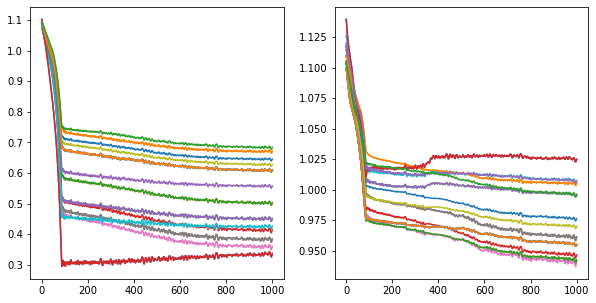

In [92]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(np.array(radii_traj))
plt.subplot(1,2,2)
plt.plot(np.array(scales_traj))

Text(0, 0.5, 'hydration free energy error (kcal/mol)')

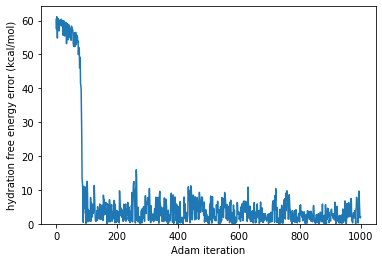

In [93]:
loss_traj_in_kcalmol = [(b * kT).value_in_unit(unit.kilocalorie_per_mole) for b in batch_losses]
plt.plot(loss_traj_in_kcalmol)
plt.ylim(0,)
plt.xlabel('Adam iteration')
plt.ylabel('hydration free energy error (kcal/mol)')